In [1]:
import tensorflow as tf
import keras
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import random
%matplotlib inline
from tensorflow.data import Dataset, Iterator

/Users/lifengwei/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Test dataset API of Tensorflow

This is the first time that I try to use the dataset API in Tnesorflow. I will need this when doing updates in PPO. 

Below is an example where I create a reference numpy array (X) with shape (20000, 3) and a random tensorflow variable (Y) with shape (20000, 3). The goal is to use SGD (Adam actually) to force the values in a row of Y close to the value of X that is in the same row. But the order will be changed by a random permutation.

In [2]:
X = np.random.randint(low=0, high=10, size=60000).reshape(20000, 3)
row = np.arange(20000).reshape(20000, 1)
z = np.zeros((20000, 3))
for i in range(20000):
    z[i,:] = np.random.permutation(3)
initial_value = np.random.randn(20000, 3)

In [3]:
Y = tf.Variable(initial_value=initial_value, trainable=True)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
#Notice the use of tf.gather and tf.gather_nd here
#Experience: tf.gather can be used if you want to pick up slices from original tensor
#            tf.gather_nd can be used if you want to pick up some locations from original tensor
input_placeholder = tf.placeholder('float32', X.shape)
row_placeholder = tf.placeholder('int32', row.shape)
index_placeholder = tf.placeholder('int32', z.shape)
dataset = Dataset.from_tensor_slices((input_placeholder, row_placeholder, index_placeholder))
dataset = dataset.shuffle(buffer_size = 40000)
dataset = dataset.batch(64)
dataset = dataset.repeat(1000)
iterator = dataset.make_initializable_iterator()
X_sampled, row_sampled, index_sampled = iterator.get_next()
row_sampled = tf.squeeze(row_sampled, 1)
length = tf.shape(X_sampled)[0]
indices = tf.stack([tf.range(length)]*3, axis=-1)
indices = tf.stack([indices, index_sampled], axis=-1)#after these two stacks, we can use tf.gather to rotate each row
                                                     #with its own permutation
Y_sampled = tf.gather(Y, row_sampled)#pick the sampled part of Y. Now we can do tf.gather to rotate this part
loss = tf.losses.mean_squared_error(tf.gather_nd(Y_sampled, indices), X_sampled)
train = tf.train.AdamOptimizer(0.001).minimize(loss)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [5]:
#Conclusion: Define everythin first and use a while to loop over the dataset
#            Only use feed_dict when initializing iterator
losses = []
length_history = []
with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
    sess.run(iterator.initializer, feed_dict={input_placeholder:X, 
                                              row_placeholder:row, 
                                              index_placeholder:z})
    while True:
        try:
            _, temp_loss, temp_length = sess.run([train, loss, length])
            length_history.append(temp_length)
            losses.append(temp_loss)
        except tf.errors.OutOfRangeError:
            break
    Y_numpy = sess.run(Y)

In [6]:
#I left this block here only to show that when using tensorflow dataset api, it will not connect different epochs
from collections import Counter
Counter(length_history)

Counter({32: 1000, 64: 312000})

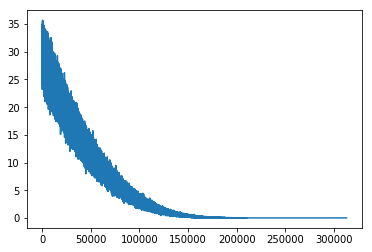

In [7]:
plt.plot(losses)

In [8]:
#Check results by first 5 rows, remember that rotation of Y equal to X, not rotation of X equal to Y
X[:5], Y_numpy[:5], z[:5]

(array([[1, 2, 8],
        [1, 2, 1],
        [1, 3, 8],
        [4, 2, 6],
        [4, 1, 8]]), array([[1.99999999, 1.00000005, 8.00000035],
        [2.00000003, 1.00000006, 1.00000003],
        [8.00000007, 3.00000002, 0.99112362],
        [2.00000003, 4.00000001, 6.00000005],
        [4.00000001, 8.00000004, 1.00000005]]), array([[1., 0., 2.],
        [2., 0., 1.],
        [2., 1., 0.],
        [1., 0., 2.],
        [0., 2., 1.]]))

# Create Environment

In [9]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
State shape:  (8,)
Number of actions:  4


# Networks

In [10]:
def create_model(layers, output=None):
    model = keras.Sequential()
    for dim in layers[:-1]:
        model.add(keras.layers.Dense(dim, activation='relu'))
    model.add(keras.layers.Dense(layers[-1], activation=output))
    return model

# PPO Agent

In [11]:
class PPO_Discrete:
    
    def __init__(self, env, learning_rate, learning_time, batch_size, buffer_size, parallel_num, tau, beta, gamma, eps, clip):
        
        self.lr = learning_rate #learning rate
        self.lt = learning_time #how many iterations to go through for each data
        self.batch_size = batch_size #batch size for learning
        self.buffer_size = buffer_size #how many experiences to 'replay' when learning
        self.initial_buffer_size = buffer_size #control the minimum number of buffer size
        self.parallel_num = parallel_num #how many tests to run 'simultaneously' or sequentially without learning
        self.env = env
        self.action_size = env.action_space.n
        self.state_size = env.observation_space.shape[0]
        self.tau = tau #parameter for GAE
        self.gamma = gamma #decay for future reward
        self.beta = beta #parameter for KL divergence
        self.eps = eps #allowed error range for likelihood ratio
        self.clip = clip #maximum allowed norm of gradient
        
        #Networks
        self.actor = create_model(layers=[64, 64, 4], output=tf.nn.log_softmax)
        self.critic = create_model(layers=[64, 64, 1])
        
        #a quick way to get action values, state values
        self.states = tf.placeholder(dtype=tf.float32, shape=(None, self.state_size))
        self.log_probs = self.actor(self.states)
        self.state_values = self.critic(self.states)
        
        #The following graph computes the loss and do the training
        self.sampled_states = tf.placeholder(dtype=tf.float32, shape=(None, self.state_size))
        self.sampled_actions = tf.placeholder(dtype=tf.int32, shape=(None, 1))
        self.sampled_log_probs = tf.placeholder(dtype=tf.float32, shape=(None, self.action_size))
        self.sampled_advantages = tf.placeholder(dtype=tf.float32, shape=(None, 1))
        self.sampled_returns = tf.placeholder(dtype=tf.float32, shape=(None, 1))
        
        #Create the graph for learning, with everything calculated
        self.shape = tf.shape(self.sampled_states)[0]
        self.indices = tf.stack([tf.range(self.shape), tf.reshape(self.sampled_actions, [-1])], axis=-1)#used to extract desired ratios
        self.new_log_probs = self.actor(self.sampled_states)
        self.ratio = tf.exp(self.new_log_probs - self.sampled_log_probs) 
        self.ratio = tf.gather_nd(self.ratio, self.indices)#pick out desired ratios
        self.ratio = tf.expand_dims(self.ratio, axis=-1)#add one dimension so that it is a column vector
        self.KL = -tf.reduce_sum(tf.exp(self.sampled_log_probs)*(self.new_log_probs - self.sampled_log_probs), axis=1, keepdims=True)
        
        self.estimated_values = self.critic(self.sampled_states)
        
        self.actor_loss = -tf.reduce_mean(tf.minimum(x=self.ratio*self.sampled_advantages, y=tf.clip_by_value(self.ratio, 1-self.eps, 1+self.eps)*self.sampled_advantages))
        self.actor_loss += self.beta * tf.reduce_mean(self.KL)
        
        self.critic_loss = tf.losses.mean_squared_error(self.estimated_values, self.sampled_returns)
        
        self.total_loss = self.actor_loss + self.critic_loss
        
        self.optimizer = tf.train.AdamOptimizer(self.lr)
        self.gradients, self.variables = zip(*self.optimizer.compute_gradients(self.total_loss))
        self.gradients, _ = tf.clip_by_global_norm(self.gradients, self.clip)
        self.optimize = self.optimizer.apply_gradients(zip(self.gradients, self.variables))
        
        self.session = tf.Session()
        self.session.run(tf.initializers.global_variables())
        
    def act(self, state):
        
        state = np.expand_dims(state, 0)
        log_probs = self.session.run(self.log_probs, feed_dict={self.states:state})
        log_probs = np.squeeze(log_probs, 0)
        probs = np.exp(log_probs)
        action = int(np.random.choice(self.action_size, size=1, replace=False, p=probs))
        
        return action, log_probs
        
    def clean_memory(self):
        #clean memory to start a new training phase
        
        self.state_numpy = np.zeros((self.buffer_size * self.parallel_num, self.state_size))
        self.action_numpy = np.zeros((self.buffer_size * self.parallel_num, 1))
        self.log_prob_numpy = np.zeros((self.buffer_size * self.parallel_num, self.action_size))
        self.advantage_numpy = np.zeros((self.buffer_size * self.parallel_num, 1))
        self.reward_numpy = np.zeros((self.buffer_size * self.parallel_num, 1))
        self.return_numpy = np.zeros((self.buffer_size * self.parallel_num, 1))
        self.done_numpy = np.zeros((self.buffer_size * self.parallel_num, 1))
        
    def learn(self, method):
        #Update Actor and Critic based on collected trajectories
        if (method == 'row-wise'):
            temp_advantage = np.zeros((self.buffer_size, self.parallel_num))
            for i in range(self.parallel_num):
                index = range(i*self.buffer_size, (i+1)*self.buffer_size)
                temp_advantage[:, i] = self.advantage_numpy[index, :].reshape(-1).copy()
            temp_advantage = temp_advantage - np.mean(temp_advantage, axis=1, keepdims=True)
            temp_advantage = temp_advantage/np.std(temp_advantage, axis=1, keepdims=True)
            
            for i in range(self.parallel_num):
                index = range(i*self.buffer_size, (i+1)*self.buffer_size)
                self.advantage_numpy[index, :] = temp_advantage[range(self.buffer_size), i].reshape(-1, 1).copy()
        else:
            self.advantage_numpy = (self.advantage_numpy - np.mean(self.advantage_numpy))/np.std(self.advantage_numpy)
        
        total_num = self.buffer_size * self.parallel_num
        batch_num = int(np.ceil(total_num/self.batch_size))
        for _ in range(self.lt):
            index = list(np.random.permutation(total_num))
            for batch_idx in range(batch_num):
                slices = index[(batch_idx*self.batch_size):min((batch_idx+1)*self.batch_size, total_num)]
                self.session.run(self.optimize, feed_dict = {self.sampled_states: self.state_numpy[slices,:], 
                                                             self.sampled_actions: self.action_numpy[slices, :],
                                                             self.sampled_log_probs: self.log_prob_numpy[slices, :],
                                                             self.sampled_advantages: self.advantage_numpy[slices, :],
                                                             self.sampled_returns: self.return_numpy[slices, :]})
                
                
    def train(self, num_iterations, reward_cut, method1='TD', method2='row-wise'):
        
        reward_recorder = []
        reward_window = deque(maxlen=100)
        mean_reward_recorder = []
        length_of_episodes = []
        
        self.clean_memory()
        
        parallel_counter = 0 #Saves the number of finished trajectories
        current_length = 0 #Saves the number of experiences in the current trajectory
        state_temp_numpy = np.zeros((self.buffer_size+1, self.state_size))
        for i in range(1, 1+num_iterations):
            t = 0
            done = False
            episodic_reward = 0
            if current_length == self.buffer_size:
                #This means we should start a 'new', 'parallel' trajectory
                current_length = 0
                state_temp_numpy = np.zeros((self.buffer_size+1, self.state_size))
                parallel_counter += 1
            if parallel_counter == self.parallel_num:
                #This means we have already got enough trajectories, we should learn from them and update policy
                parallel_counter = 0
                self.learn(method2)
                if i>20:
                    new_value = max(int(1.6*np.quantile(length_of_episodes[-20:], 0.3)), int(1.6*np.mean(length_of_episodes[-20:])), self.initial_buffer_size)
                    if new_value!=self.buffer_size:
                        self.buffer_size = new_value 
                        state_temp_numpy = np.zeros((self.buffer_size+1, self.state_size))   
                #clean all memories
                self.clean_memory()
            
            state = self.env.reset()
            while not done:
                t += 1
                action, log_probs = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                if current_length < self.buffer_size:
                    #This means we can add experience to current trajectory
                    state_temp_numpy[current_length,:] = state.copy()
                    self.state_numpy[self.buffer_size * parallel_counter + current_length, :] = state.copy()
                    self.action_numpy[self.buffer_size * parallel_counter + current_length,0] = action
                    self.log_prob_numpy[self.buffer_size * parallel_counter + current_length, :] = log_probs.copy()
                    self.done_numpy[self.buffer_size * parallel_counter + current_length,0] = done
                    if reward <= -reward_cut:
                        self.reward_numpy[self.buffer_size * parallel_counter + current_length,0] = -reward_cut
                    elif reward >= reward_cut:
                        self.reward_numpy[self.buffer_size * parallel_counter + current_length,0] = reward_cut
                    else:
                        self.reward_numpy[self.buffer_size * parallel_counter + current_length,0] = reward
                    current_length += 1
                    if current_length == self.buffer_size:
                        #Now a trajectory is all collected. It's time to calculate and save it's return and GAE 
                        state_temp_numpy[self.buffer_size, :] = next_state.copy() #To calculate advantage function, etc
                        #Calculate the advantage for this expeirence
                        advantage_temp_numpy = np.zeros((self.buffer_size+1, 1))
                        return_temp_numpy = np.zeros((self.buffer_size+1, 1))
                        state_values = self.session.run(self.state_values, feed_dict={self.states:state_temp_numpy})
                        for j in reversed(range(self.buffer_size)):
                            done = self.done_numpy[self.buffer_size * parallel_counter + j,0].copy()
                            reward = self.reward_numpy[self.buffer_size * parallel_counter + j,0].copy()
                            current_value = state_values[j,:].copy()
                            next_value = state_values[j+1,:].copy()
                            delta = reward + (1-done)*self.gamma*next_value - current_value
                            advantage_temp_numpy[j] =  delta + (1-done)*self.gamma*self.tau*advantage_temp_numpy[j+1]
                            if (method1 == 'TD'):
                                return_temp_numpy[j] = reward + (1-done)*self.gamma*next_value
                            else:
                                return_temp_numpy[j] = reward + (1-done)*self.gamma*return_temp_numpy[j+1]
                        self.advantage_numpy[range(self.buffer_size*parallel_counter, self.buffer_size*(parallel_counter+1)),:] = advantage_temp_numpy[:-1,:].copy()
                        self.return_numpy[range(self.buffer_size*parallel_counter, self.buffer_size*(parallel_counter+1)),:] = return_temp_numpy[:-1,:].copy()
                    
                state = next_state.copy()
                episodic_reward += reward
            
            #End of an episode. Record the reward information
            reward_recorder.append(episodic_reward)
            reward_window.append(episodic_reward)
            mean_reward_recorder.append(np.mean(reward_window))
            length_of_episodes.append(t)
                
            print('\rEpisode {}\tEpisodic Score: {:.2f}\tAverage Score: {:.2f}\t Current buffer size {}\t'.format(i, episodic_reward, mean_reward_recorder[-1], self.buffer_size), end='')
            if i % 100 == 0:
                print()
            
        return reward_recorder, mean_reward_recorder, length_of_episodes   

# Experiments

In [12]:
import matplotlib.pyplot as plt

def plot_result(scores, means, suptitle):
    fig = plt.figure(figsize=(20,10))
    fig.suptitle(suptitle)
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    average = np.mean(means, axis=0)
    error_bar = np.std(means, axis=0)/np.sqrt(15)
    upper = np.amax(means, axis=0)
    lower = np.amin(means, axis=0)
    ax1.plot(range(2000), average, label='Trajectory of moving average', color='yellow')
    ax1.plot(range(2000), upper, label='Upper bound', color='black')
    ax1.plot(range(2000), lower, label='Lower bound', color='black')
    ax1.fill_between(range(2000), average+1.96*error_bar, average-1.96*error_bar, alpha=0.5)
    ax1.plot(range(2000), 200*np.ones(2000), label='Benchmark',color='gray')
    ax1.set_ylabel('Average')
    ax1.set_xlabel('Episode #')
    ax1.legend(loc=4)
    ax1.set_ylim([-500, 300])
    ax1.set_title('Trajectory for moving average')
    
    average = np.mean(scores, axis=0)
    error_bar = np.std(scores, axis=0)/np.sqrt(15)
    upper = np.amax(scores, axis=0)
    lower = np.amin(scores, axis=0)
    ax2.plot(range(2000), average, label='Trajectory of episodic scores', color='yellow')
    ax2.fill_between(range(2000), average+1.96*error_bar, average-1.96*error_bar, alpha=0.5)
    ax2.plot(range(2000), upper, label='Upper bound', color='black')
    ax2.plot(range(2000), lower, label='Lower bound', color='black')
    ax2.plot(range(2000), 200*np.ones(2000), label='Benchmark',color='gray')
    ax2.set_ylabel('Score')
    ax2.set_xlabel('Episode #')
    ax2.legend(loc=4)
    ax2.set_ylim([-500, 300])
    ax2.set_title('Trajectory for episodic rewards')
    
    plt.show()

In [13]:
means = np.zeros((15, 2000))
scores = np.zeros((15, 2000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    tf.reset_default_graph()
    agent = PPO_Discrete(env=env, learning_rate=0.001, learning_time=4, batch_size=64, buffer_size=300, parallel_num=5, tau=0.995, beta=0, gamma=0.99, eps=0.2, clip=1)
    scores[i, ], means[i, ], _ = agent.train(num_iterations=2000, reward_cut=200, method1='TD', method2='row-wise')
    

Test No.1:
Episode 100	Episodic Score: -181.86	Average Score: -212.63	 Current buffer size 300	
Episode 200	Episodic Score: -73.34	Average Score: -154.62	 Current buffer size 300		
Episode 300	Episodic Score: -81.08	Average Score: -101.59	 Current buffer size 1279		
Episode 400	Episodic Score: -73.90	Average Score: -73.86	 Current buffer size 1600			
Episode 500	Episodic Score: 35.13	Average Score: -31.20	 Current buffer size 1251	1	
Episode 600	Episodic Score: -18.20	Average Score: -1.68	 Current buffer size 1201			
Episode 700	Episodic Score: 15.54	Average Score: 24.80	 Current buffer size 1600			
Episode 800	Episodic Score: 55.50	Average Score: 59.02	 Current buffer size 1600			
Episode 900	Episodic Score: 109.74	Average Score: 80.20	 Current buffer size 1600	
Episode 1000	Episodic Score: 82.52	Average Score: 100.22	 Current buffer size 1600	
Episode 1100	Episodic Score: 95.17	Average Score: 150.80	 Current buffer size 894			
Episode 1200	Episodic Score: 244.64	Average Score: 182.03

Episode 1300	Episodic Score: 206.44	Average Score: 186.66	 Current buffer size 516		
Episode 1400	Episodic Score: 232.55	Average Score: 202.61	 Current buffer size 427	
Episode 1500	Episodic Score: 162.05	Average Score: 208.74	 Current buffer size 436	
Episode 1600	Episodic Score: 213.68	Average Score: 215.69	 Current buffer size 420	
Episode 1700	Episodic Score: 223.18	Average Score: 207.77	 Current buffer size 395		
Episode 1800	Episodic Score: 262.88	Average Score: 206.81	 Current buffer size 334		
Episode 1900	Episodic Score: 223.42	Average Score: 210.84	 Current buffer size 358		
Episode 2000	Episodic Score: 51.85	Average Score: 203.43	 Current buffer size 330		
Test No.11:
Episode 100	Episodic Score: -154.88	Average Score: -215.37	 Current buffer size 300	
Episode 200	Episodic Score: -54.98	Average Score: -177.88	 Current buffer size 300		
Episode 300	Episodic Score: -284.60	Average Score: -166.37	 Current buffer size 865	
Episode 400	Episodic Score: -126.99	Average Score: -145.7

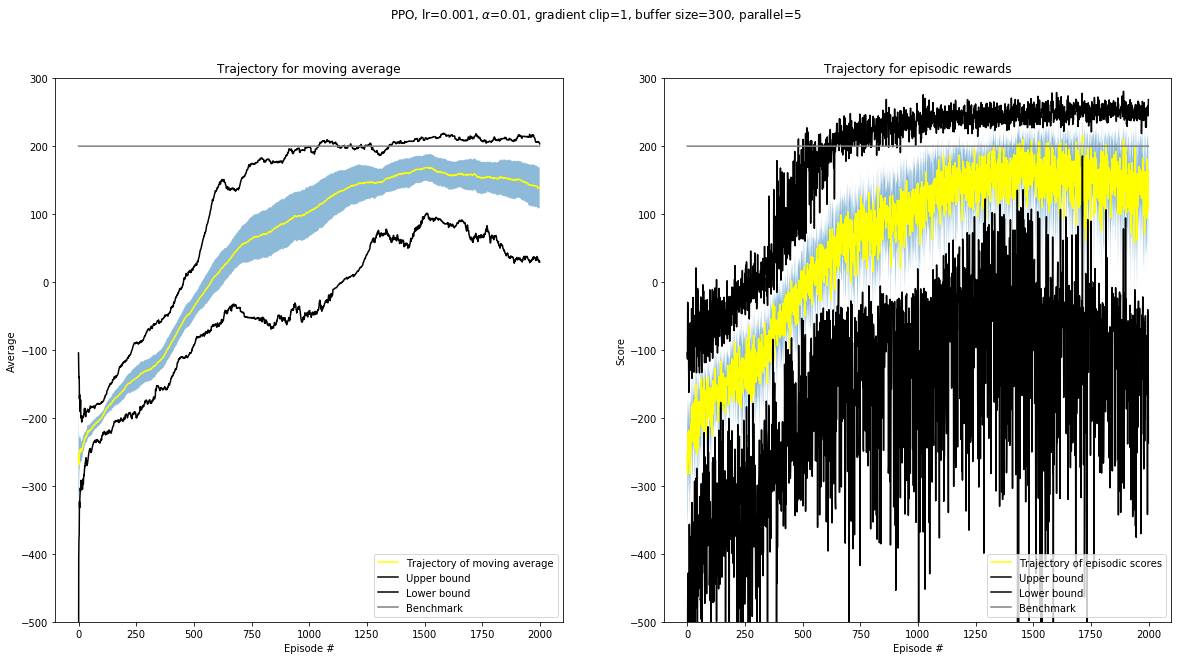

In [14]:
plot_result(scores, means, r'PPO, lr=0.001, $\alpha$=0.01, gradient clip=1, buffer size=300, parallel=5')

In [15]:
means = np.zeros((15, 2000))
scores = np.zeros((15, 2000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    tf.reset_default_graph()
    agent = PPO_Discrete(env=env, learning_rate=0.001, learning_time=4, batch_size=64, buffer_size=300, parallel_num=5, tau=0.995, beta=0, gamma=0.99, eps=0.2, clip=2)
    scores[i, ], means[i, ], _ = agent.train(num_iterations=2000, reward_cut=200, method1='TD', method2='row-wise')
    

Test No.1:
Episode 100	Episodic Score: -120.97	Average Score: -189.41	 Current buffer size 300	
Episode 200	Episodic Score: -130.44	Average Score: -179.61	 Current buffer size 300	
Episode 300	Episodic Score: -78.28	Average Score: -164.54	 Current buffer size 300		
Episode 400	Episodic Score: -55.49	Average Score: -108.14	 Current buffer size 300		
Episode 500	Episodic Score: 2.60	Average Score: -70.16	 Current buffer size 770	0			
Episode 600	Episodic Score: 30.72	Average Score: -48.32	 Current buffer size 1174			
Episode 700	Episodic Score: 5.96	Average Score: -34.57	 Current buffer size 574	4			
Episode 800	Episodic Score: -84.49	Average Score: -28.28	 Current buffer size 982			
Episode 900	Episodic Score: 7.59	Average Score: -7.07	 Current buffer size 989	9				
Episode 1000	Episodic Score: 253.43	Average Score: 46.84	 Current buffer size 675	
Episode 1100	Episodic Score: 210.88	Average Score: 109.27	 Current buffer size 442	
Episode 1200	Episodic Score: -44.08	Average Score: 119.63

Episode 1300	Episodic Score: 76.10	Average Score: 39.27	 Current buffer size 1600		
Episode 1400	Episodic Score: 134.51	Average Score: 90.68	 Current buffer size 1600	
Episode 1500	Episodic Score: 133.10	Average Score: 109.65	 Current buffer size 1203	
Episode 1600	Episodic Score: 214.71	Average Score: 141.95	 Current buffer size 815			
Episode 1700	Episodic Score: 188.06	Average Score: 181.20	 Current buffer size 525		
Episode 1800	Episodic Score: 217.14	Average Score: 185.85	 Current buffer size 507		
Episode 1900	Episodic Score: 248.85	Average Score: 156.83	 Current buffer size 471		
Episode 2000	Episodic Score: 222.13	Average Score: 202.87	 Current buffer size 476		
Test No.11:
Episode 100	Episodic Score: -162.07	Average Score: -198.94	 Current buffer size 300	
Episode 200	Episodic Score: -121.52	Average Score: -168.37	 Current buffer size 300	
Episode 300	Episodic Score: -102.95	Average Score: -162.16	 Current buffer size 300	
Episode 400	Episodic Score: -28.25	Average Score: -89.

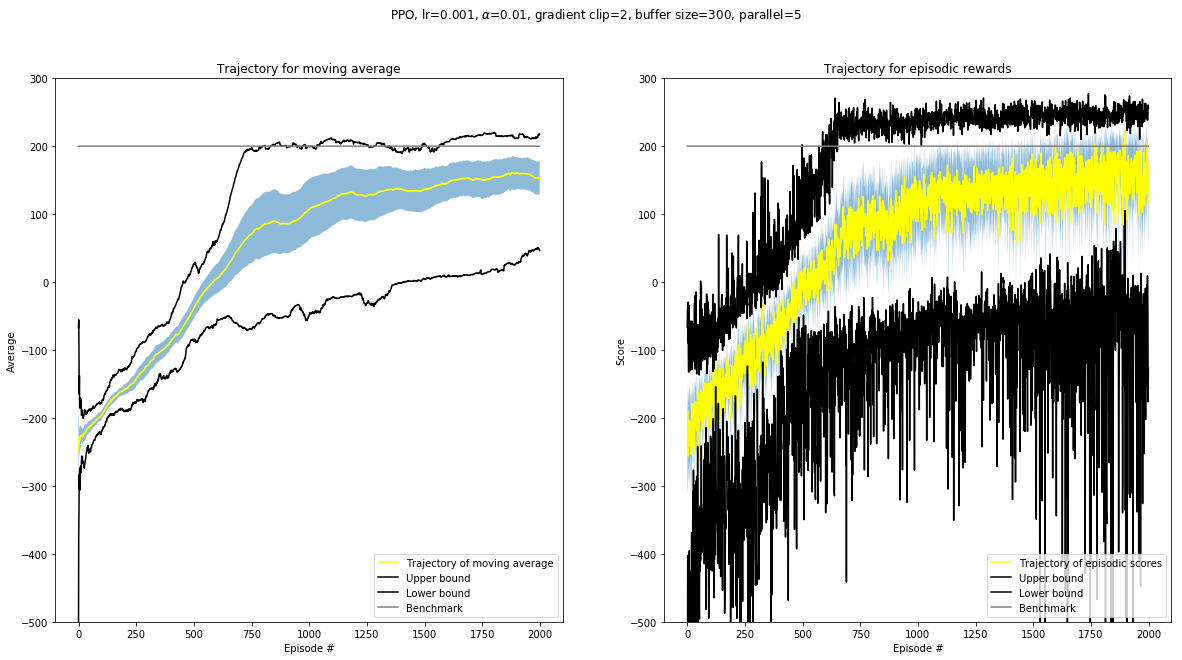

In [16]:
plot_result(scores, means, r'PPO, lr=0.001, $\alpha$=0.01, gradient clip=2, buffer size=300, parallel=5')

In [13]:
means = np.zeros((15, 2000))
scores = np.zeros((15, 2000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    tf.reset_default_graph()
    agent = PPO_Discrete(env=env, learning_rate=0.001, learning_time=4, batch_size=64, buffer_size=300, parallel_num=5, tau=0.995, beta=0, gamma=0.99, eps=0.2, clip=5)
    scores[i, ], means[i, ], _ = agent.train(num_iterations=2000, reward_cut=200, method1='TD', method2='row-wise')
    

Test No.1:
Episode 100	Episodic Score: -155.67	Average Score: -212.21	 Current buffer size 300	
Episode 200	Episodic Score: -237.51	Average Score: -161.82	 Current buffer size 300	
Episode 300	Episodic Score: -53.99	Average Score: -101.28	 Current buffer size 419		
Episode 400	Episodic Score: 134.91	Average Score: -29.62	 Current buffer size 1600		
Episode 500	Episodic Score: 192.54	Average Score: 139.26	 Current buffer size 692		
Episode 600	Episodic Score: 186.81	Average Score: 150.46	 Current buffer size 797		
Episode 700	Episodic Score: 167.76	Average Score: 126.53	 Current buffer size 664		
Episode 800	Episodic Score: 155.05	Average Score: 177.81	 Current buffer size 649		
Episode 900	Episodic Score: 224.98	Average Score: 167.91	 Current buffer size 619		
Episode 1000	Episodic Score: 216.01	Average Score: 194.87	 Current buffer size 620	
Episode 1100	Episodic Score: 189.48	Average Score: 182.97	 Current buffer size 421		
Episode 1200	Episodic Score: 235.96	Average Score: 197.78	 C

Episode 1700	Episodic Score: 212.72	Average Score: 155.01	 Current buffer size 1169	
Episode 1800	Episodic Score: 26.13	Average Score: 143.26	 Current buffer size 745			
Episode 1900	Episodic Score: -17.65	Average Score: 136.11	 Current buffer size 742		
Episode 2000	Episodic Score: 56.77	Average Score: 130.56	 Current buffer size 813			
Test No.6:
Episode 100	Episodic Score: -153.11	Average Score: -229.10	 Current buffer size 300	
Episode 200	Episodic Score: -65.53	Average Score: -145.75	 Current buffer size 300		
Episode 300	Episodic Score: -62.17	Average Score: -107.85	 Current buffer size 706		
Episode 400	Episodic Score: -15.49	Average Score: -88.25	 Current buffer size 1600			
Episode 500	Episodic Score: -28.13	Average Score: -27.69	 Current buffer size 1600		
Episode 600	Episodic Score: -15.09	Average Score: -4.70	 Current buffer size 1410			
Episode 700	Episodic Score: 46.56	Average Score: 7.05	 Current buffer size 1600	0		
Episode 800	Episodic Score: 63.95	Average Score: 52.74

Episode 1300	Episodic Score: 208.83	Average Score: 163.54	 Current buffer size 495		
Episode 1400	Episodic Score: 236.51	Average Score: 176.07	 Current buffer size 514		
Episode 1500	Episodic Score: 200.04	Average Score: 182.40	 Current buffer size 419	
Episode 1600	Episodic Score: 218.74	Average Score: 180.22	 Current buffer size 552		
Episode 1700	Episodic Score: 198.87	Average Score: 177.16	 Current buffer size 378		
Episode 1800	Episodic Score: -20.68	Average Score: 115.19	 Current buffer size 346		
Episode 1900	Episodic Score: 223.08	Average Score: 131.70	 Current buffer size 510		
Episode 2000	Episodic Score: 261.55	Average Score: 192.31	 Current buffer size 388		
Test No.11:
Episode 100	Episodic Score: -2.22	Average Score: -194.28	 Current buffer size 300		
Episode 200	Episodic Score: -101.99	Average Score: -139.23	 Current buffer size 300	
Episode 300	Episodic Score: -76.12	Average Score: -83.70	 Current buffer size 422			
Episode 400	Episodic Score: 55.06	Average Score: -50.45

Episode 900	Episodic Score: 179.46	Average Score: 201.76	 Current buffer size 465		
Episode 1000	Episodic Score: 233.18	Average Score: 198.87	 Current buffer size 418	
Episode 1100	Episodic Score: 201.06	Average Score: 211.54	 Current buffer size 406		
Episode 1200	Episodic Score: 228.04	Average Score: 217.41	 Current buffer size 445	
Episode 1300	Episodic Score: 192.01	Average Score: 203.36	 Current buffer size 412		
Episode 1400	Episodic Score: 227.13	Average Score: 219.10	 Current buffer size 344		
Episode 1500	Episodic Score: 238.19	Average Score: 194.93	 Current buffer size 394		
Episode 1600	Episodic Score: 224.71	Average Score: 225.64	 Current buffer size 449	
Episode 1700	Episodic Score: 130.12	Average Score: 213.94	 Current buffer size 415	
Episode 1800	Episodic Score: 226.11	Average Score: 206.43	 Current buffer size 367		
Episode 1900	Episodic Score: 160.00	Average Score: 221.61	 Current buffer size 355		
Episode 2000	Episodic Score: 260.84	Average Score: 213.11	 Current buf

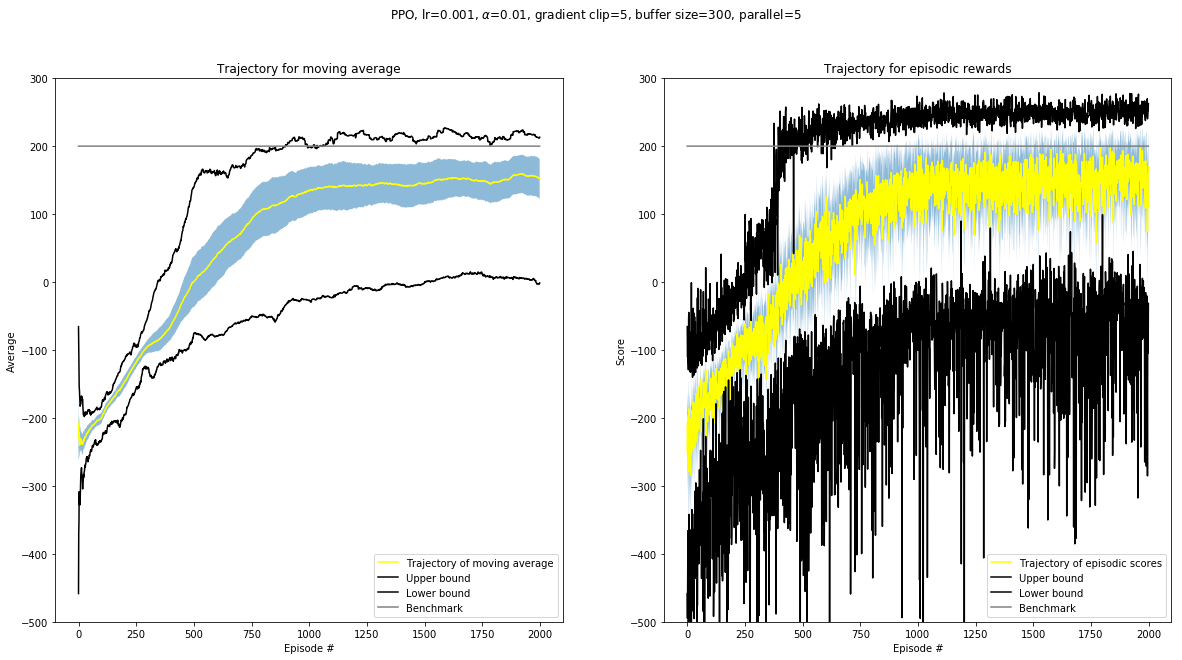

In [14]:
plot_result(scores, means, r'PPO, lr=0.001, $\alpha$=0.01, gradient clip=5, buffer size=300, parallel=5')

In [15]:
means = np.zeros((15, 2000))
scores = np.zeros((15, 2000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    tf.reset_default_graph()
    agent = PPO_Discrete(env=env, learning_rate=0.0005, learning_time=4, batch_size=64, buffer_size=300, parallel_num=5, tau=0.995, beta=0, gamma=0.99, eps=0.2, clip=1)
    scores[i, ], means[i, ], _ = agent.train(num_iterations=2000, reward_cut=200, method1='TD', method2='row-wise')
    

Test No.1:
Episode 100	Episodic Score: -170.61	Average Score: -207.32	 Current buffer size 300	
Episode 200	Episodic Score: -47.24	Average Score: -177.05	 Current buffer size 300		
Episode 300	Episodic Score: -136.64	Average Score: -182.95	 Current buffer size 300	
Episode 400	Episodic Score: -82.99	Average Score: -121.06	 Current buffer size 300		
Episode 500	Episodic Score: -54.88	Average Score: -102.48	 Current buffer size 942		
Episode 600	Episodic Score: -72.33	Average Score: -74.42	 Current buffer size 1600		
Episode 700	Episodic Score: -103.89	Average Score: -39.79	 Current buffer size 1600	
Episode 800	Episodic Score: -9.31	Average Score: -1.96	 Current buffer size 1600				
Episode 900	Episodic Score: 63.34	Average Score: 51.66	 Current buffer size 1600			
Episode 1000	Episodic Score: 221.10	Average Score: 109.68	 Current buffer size 824	
Episode 1100	Episodic Score: 234.31	Average Score: 147.25	 Current buffer size 479	
Episode 1200	Episodic Score: 230.24	Average Score: 147.34

Episode 1700	Episodic Score: 209.26	Average Score: 189.36	 Current buffer size 483		
Episode 1800	Episodic Score: 232.11	Average Score: 183.37	 Current buffer size 390		
Episode 1900	Episodic Score: 195.11	Average Score: 163.13	 Current buffer size 379		
Episode 2000	Episodic Score: 234.38	Average Score: 164.67	 Current buffer size 381		
Test No.6:
Episode 100	Episodic Score: -157.59	Average Score: -225.52	 Current buffer size 300	
Episode 200	Episodic Score: -86.36	Average Score: -173.94	 Current buffer size 300		
Episode 300	Episodic Score: -38.76	Average Score: -188.21	 Current buffer size 322		
Episode 400	Episodic Score: -77.65	Average Score: -98.20	 Current buffer size 569			
Episode 500	Episodic Score: 25.40	Average Score: -47.34	 Current buffer size 896				
Episode 600	Episodic Score: 59.87	Average Score: 14.48	 Current buffer size 1600				
Episode 700	Episodic Score: 118.95	Average Score: 91.05	 Current buffer size 1113		
Episode 800	Episodic Score: 151.95	Average Score: 125.8

Episode 1300	Episodic Score: 169.30	Average Score: 174.79	 Current buffer size 812		
Episode 1400	Episodic Score: -27.94	Average Score: 184.17	 Current buffer size 648	
Episode 1500	Episodic Score: 174.73	Average Score: 188.44	 Current buffer size 586		
Episode 1600	Episodic Score: 210.36	Average Score: 178.42	 Current buffer size 529		
Episode 1700	Episodic Score: 220.52	Average Score: 182.54	 Current buffer size 406		
Episode 1800	Episodic Score: 205.66	Average Score: 201.88	 Current buffer size 468		
Episode 1900	Episodic Score: 226.25	Average Score: 205.85	 Current buffer size 386		
Episode 2000	Episodic Score: 215.85	Average Score: 214.12	 Current buffer size 418	
Test No.11:
Episode 100	Episodic Score: -230.06	Average Score: -184.19	 Current buffer size 300	
Episode 200	Episodic Score: -226.67	Average Score: -177.62	 Current buffer size 300	
Episode 300	Episodic Score: -108.38	Average Score: -138.75	 Current buffer size 392	
Episode 400	Episodic Score: -13.16	Average Score: -128.

Episode 800	Episodic Score: -23.74	Average Score: 59.70	 Current buffer size 1600	
Episode 900	Episodic Score: 92.63	Average Score: 80.25	 Current buffer size 1600		
Episode 1000	Episodic Score: 208.98	Average Score: 89.59	 Current buffer size 1279	
Episode 1100	Episodic Score: 45.45	Average Score: 125.78	 Current buffer size 702		
Episode 1200	Episodic Score: -50.29	Average Score: 170.89	 Current buffer size 753	
Episode 1300	Episodic Score: 177.59	Average Score: 173.42	 Current buffer size 619	
Episode 1400	Episodic Score: 185.46	Average Score: 164.17	 Current buffer size 432	
Episode 1500	Episodic Score: 228.76	Average Score: 166.00	 Current buffer size 494	
Episode 1600	Episodic Score: 211.90	Average Score: 191.73	 Current buffer size 506	
Episode 1700	Episodic Score: 23.08	Average Score: 194.63	 Current buffer size 506		
Episode 1800	Episodic Score: 34.64	Average Score: 181.80	 Current buffer size 534		
Episode 1900	Episodic Score: 205.60	Average Score: 192.73	 Current buffer size

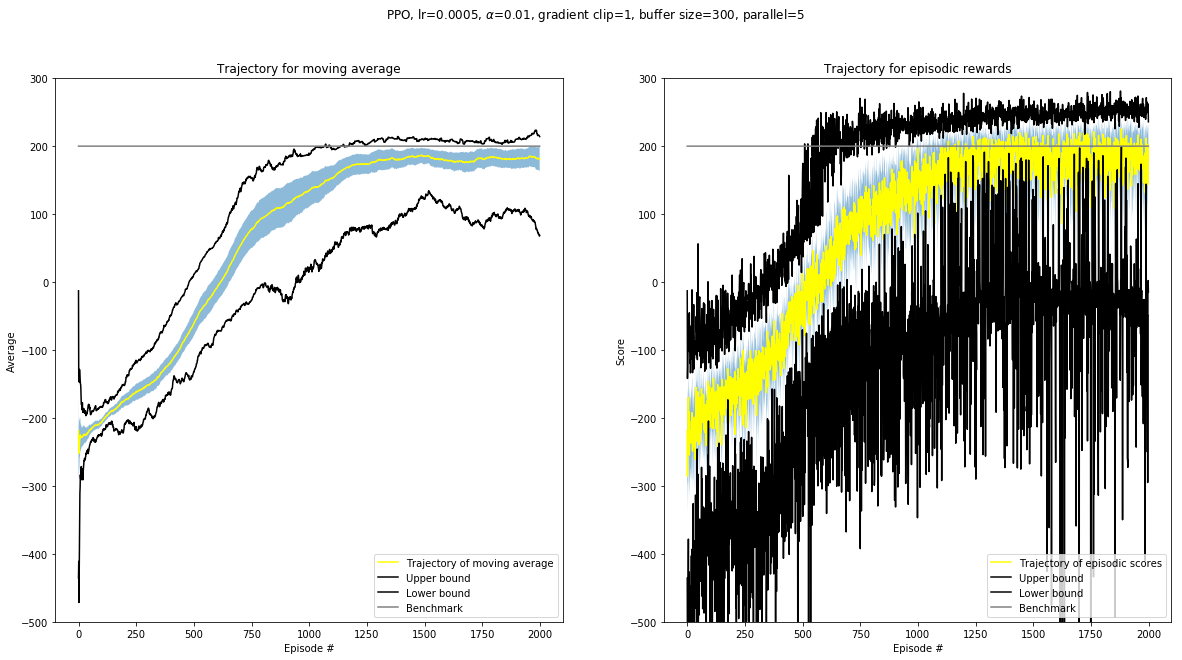

In [16]:
plot_result(scores, means, r'PPO, lr=0.0005, $\alpha$=0.01, gradient clip=1, buffer size=300, parallel=5')

In [17]:
means = np.zeros((15, 2000))
scores = np.zeros((15, 2000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    tf.reset_default_graph()
    agent = PPO_Discrete(env=env, learning_rate=0.0005, learning_time=4, batch_size=64, buffer_size=300, parallel_num=5, tau=0.995, beta=0, gamma=0.99, eps=0.2, clip=2)
    scores[i, ], means[i, ], _ = agent.train(num_iterations=2000, reward_cut=200, method1='TD', method2='row-wise')
    

Test No.1:
Episode 100	Episodic Score: -221.84	Average Score: -214.73	 Current buffer size 300	
Episode 200	Episodic Score: -64.27	Average Score: -171.20	 Current buffer size 300		
Episode 300	Episodic Score: -71.16	Average Score: -148.80	 Current buffer size 406		
Episode 400	Episodic Score: -15.77	Average Score: -75.61	 Current buffer size 450			
Episode 500	Episodic Score: 34.42	Average Score: -33.70	 Current buffer size 982		9	
Episode 600	Episodic Score: -19.48	Average Score: 24.56	 Current buffer size 1028		
Episode 700	Episodic Score: 165.72	Average Score: 26.46	 Current buffer size 1600		
Episode 800	Episodic Score: -63.98	Average Score: 24.98	 Current buffer size 1363		
Episode 900	Episodic Score: 173.19	Average Score: 73.07	 Current buffer size 1600		
Episode 1000	Episodic Score: 117.03	Average Score: 74.80	 Current buffer size 1171	
Episode 1100	Episodic Score: 71.13	Average Score: 80.55	 Current buffer size 1600		
Episode 1200	Episodic Score: 212.68	Average Score: 95.68	 Cu

Episode 1700	Episodic Score: 218.35	Average Score: 202.64	 Current buffer size 426	
Episode 1800	Episodic Score: 206.94	Average Score: 198.91	 Current buffer size 489	
Episode 1900	Episodic Score: 223.95	Average Score: 193.72	 Current buffer size 390	
Episode 2000	Episodic Score: 227.11	Average Score: 223.48	 Current buffer size 424	
Test No.6:
Episode 100	Episodic Score: -181.91	Average Score: -210.35	 Current buffer size 300	
Episode 200	Episodic Score: -256.86	Average Score: -199.53	 Current buffer size 300	
Episode 300	Episodic Score: -293.08	Average Score: -153.47	 Current buffer size 300	
Episode 400	Episodic Score: -84.82	Average Score: -103.83	 Current buffer size 485		
Episode 500	Episodic Score: -81.33	Average Score: -115.47	 Current buffer size 1539		
Episode 600	Episodic Score: -50.72	Average Score: -41.41	 Current buffer size 1600			
Episode 700	Episodic Score: 66.07	Average Score: -5.68	 Current buffer size 1600	0		
Episode 800	Episodic Score: -81.44	Average Score: 35.30	

Episode 1300	Episodic Score: 169.87	Average Score: 141.69	 Current buffer size 927			
Episode 1400	Episodic Score: 194.84	Average Score: 130.49	 Current buffer size 802		
Episode 1500	Episodic Score: -212.66	Average Score: 149.54	 Current buffer size 655	
Episode 1600	Episodic Score: 216.15	Average Score: 148.30	 Current buffer size 525		
Episode 1700	Episodic Score: 204.62	Average Score: 128.12	 Current buffer size 522		
Episode 1800	Episodic Score: -99.27	Average Score: 119.87	 Current buffer size 543		
Episode 1900	Episodic Score: 209.12	Average Score: 144.19	 Current buffer size 619		
Episode 2000	Episodic Score: 213.80	Average Score: 145.83	 Current buffer size 550	
Test No.11:
Episode 100	Episodic Score: -169.19	Average Score: -195.82	 Current buffer size 300	
Episode 200	Episodic Score: -3.22	Average Score: -135.92	 Current buffer size 365			
Episode 300	Episodic Score: -245.48	Average Score: -87.21	 Current buffer size 1047	
Episode 400	Episodic Score: 13.08	Average Score: 15.9

Episode 900	Episodic Score: -102.93	Average Score: 45.21	 Current buffer size 985		
Episode 1000	Episodic Score: -30.53	Average Score: 80.09	 Current buffer size 892	
Episode 1100	Episodic Score: 203.22	Average Score: 81.35	 Current buffer size 936		
Episode 1200	Episodic Score: 171.11	Average Score: 96.03	 Current buffer size 1150	
Episode 1300	Episodic Score: 206.85	Average Score: 105.02	 Current buffer size 928		
Episode 1400	Episodic Score: 189.92	Average Score: 86.18	 Current buffer size 959			
Episode 1500	Episodic Score: 217.79	Average Score: 112.06	 Current buffer size 938		
Episode 1600	Episodic Score: -25.60	Average Score: 109.91	 Current buffer size 953		
Episode 1700	Episodic Score: -25.47	Average Score: 116.07	 Current buffer size 956		
Episode 1800	Episodic Score: 63.96	Average Score: 107.41	 Current buffer size 1079		
Episode 1900	Episodic Score: 91.23	Average Score: 123.18	 Current buffer size 1082		
Episode 2000	Episodic Score: 44.79	Average Score: 116.41	 Current buff

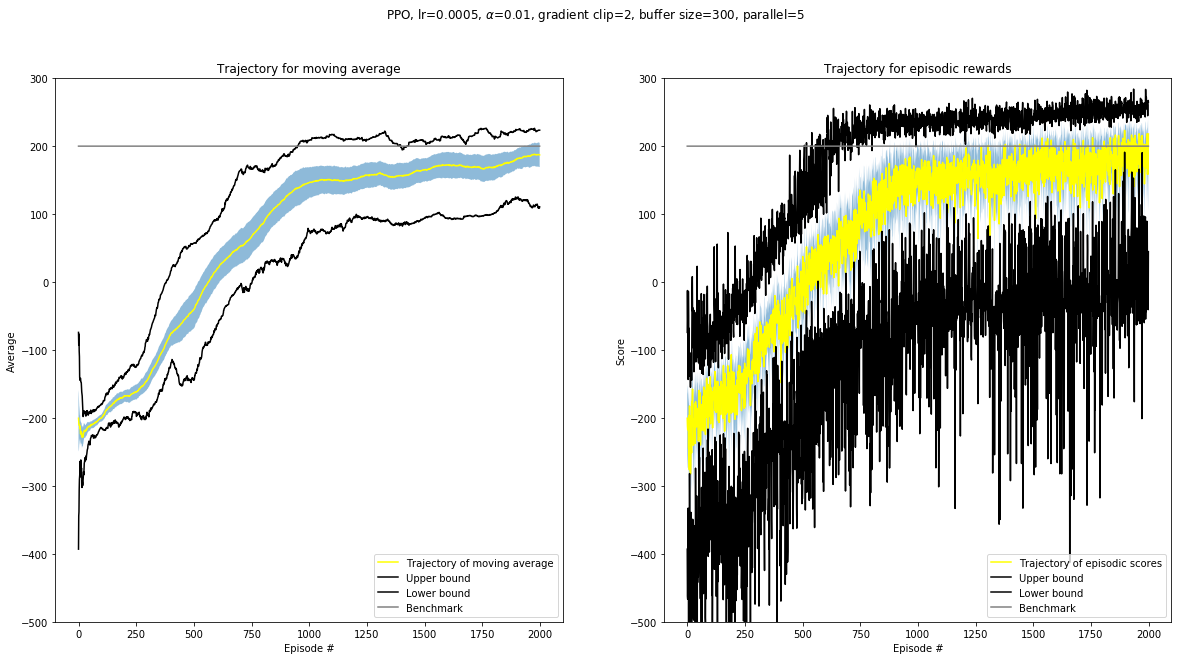

In [18]:
plot_result(scores, means, r'PPO, lr=0.0005, $\alpha$=0.01, gradient clip=2, buffer size=300, parallel=5')

In [19]:
means = np.zeros((15, 2000))
scores = np.zeros((15, 2000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    tf.reset_default_graph()
    agent = PPO_Discrete(env=env, learning_rate=0.0005, learning_time=4, batch_size=64, buffer_size=300, parallel_num=5, tau=0.995, beta=0, gamma=0.99, eps=0.2, clip=5)
    scores[i, ], means[i, ], _ = agent.train(num_iterations=2000, reward_cut=200, method1='TD', method2='row-wise')
    

Test No.1:
Episode 100	Episodic Score: -119.47	Average Score: -193.86	 Current buffer size 300	
Episode 200	Episodic Score: -91.29	Average Score: -143.77	 Current buffer size 300		
Episode 300	Episodic Score: -112.73	Average Score: -120.04	 Current buffer size 396	
Episode 400	Episodic Score: 5.54	Average Score: -86.20	 Current buffer size 1600	0			
Episode 500	Episodic Score: 48.70	Average Score: 16.39	 Current buffer size 1600				
Episode 600	Episodic Score: 90.37	Average Score: 66.98	 Current buffer size 1600		
Episode 700	Episodic Score: 216.81	Average Score: 138.51	 Current buffer size 644	
Episode 800	Episodic Score: 222.83	Average Score: 168.49	 Current buffer size 645	
Episode 900	Episodic Score: 190.07	Average Score: 145.03	 Current buffer size 693	
Episode 1000	Episodic Score: 14.78	Average Score: 151.91	 Current buffer size 426	
Episode 1100	Episodic Score: 1.68	Average Score: 134.71	 Current buffer size 379	9	
Episode 1200	Episodic Score: 207.21	Average Score: 125.86	 Curre

Episode 1700	Episodic Score: 198.08	Average Score: 182.51	 Current buffer size 420		
Episode 1800	Episodic Score: 218.19	Average Score: 158.93	 Current buffer size 368		
Episode 1900	Episodic Score: 159.72	Average Score: 145.23	 Current buffer size 682		
Episode 2000	Episodic Score: 195.15	Average Score: 168.10	 Current buffer size 631		
Test No.6:
Episode 100	Episodic Score: -124.41	Average Score: -226.75	 Current buffer size 300	
Episode 200	Episodic Score: -222.78	Average Score: -175.15	 Current buffer size 300	
Episode 300	Episodic Score: -211.07	Average Score: -148.05	 Current buffer size 464	
Episode 400	Episodic Score: -4.28	Average Score: -117.05	 Current buffer size 1579	9	
Episode 500	Episodic Score: -48.94	Average Score: 20.16	 Current buffer size 1600				
Episode 600	Episodic Score: 50.15	Average Score: 72.53	 Current buffer size 1600		
Episode 700	Episodic Score: 119.55	Average Score: 91.49	 Current buffer size 1600	
Episode 800	Episodic Score: 220.12	Average Score: 171.09

Episode 1300	Episodic Score: -10.18	Average Score: 204.12	 Current buffer size 512	
Episode 1400	Episodic Score: 216.74	Average Score: 209.91	 Current buffer size 521	
Episode 1500	Episodic Score: 182.93	Average Score: 203.99	 Current buffer size 478	
Episode 1600	Episodic Score: 254.58	Average Score: 184.95	 Current buffer size 510		
Episode 1700	Episodic Score: 187.24	Average Score: 207.97	 Current buffer size 440	
Episode 1800	Episodic Score: 227.03	Average Score: 181.41	 Current buffer size 386		
Episode 1900	Episodic Score: 234.37	Average Score: 199.45	 Current buffer size 432		
Episode 2000	Episodic Score: 257.07	Average Score: 208.10	 Current buffer size 413	
Test No.11:
Episode 100	Episodic Score: -159.78	Average Score: -201.77	 Current buffer size 300	
Episode 200	Episodic Score: -166.99	Average Score: -159.76	 Current buffer size 300	
Episode 300	Episodic Score: -193.12	Average Score: -109.16	 Current buffer size 300	
Episode 400	Episodic Score: -85.54	Average Score: -84.75	 

Episode 900	Episodic Score: 141.12	Average Score: 132.71	 Current buffer size 878		
Episode 1000	Episodic Score: 152.67	Average Score: 159.18	 Current buffer size 763	
Episode 1100	Episodic Score: 119.36	Average Score: 161.02	 Current buffer size 838	
Episode 1200	Episodic Score: 156.06	Average Score: 172.80	 Current buffer size 806	
Episode 1300	Episodic Score: 196.12	Average Score: 180.20	 Current buffer size 739	
Episode 1400	Episodic Score: 204.22	Average Score: 161.98	 Current buffer size 774		
Episode 1500	Episodic Score: 202.28	Average Score: 180.74	 Current buffer size 568		
Episode 1600	Episodic Score: 164.60	Average Score: 179.63	 Current buffer size 560	
Episode 1700	Episodic Score: 177.50	Average Score: 199.71	 Current buffer size 601	
Episode 1800	Episodic Score: 220.65	Average Score: 188.07	 Current buffer size 554	
Episode 1900	Episodic Score: 204.79	Average Score: 199.82	 Current buffer size 535		
Episode 2000	Episodic Score: 212.15	Average Score: 211.21	 Current buffer

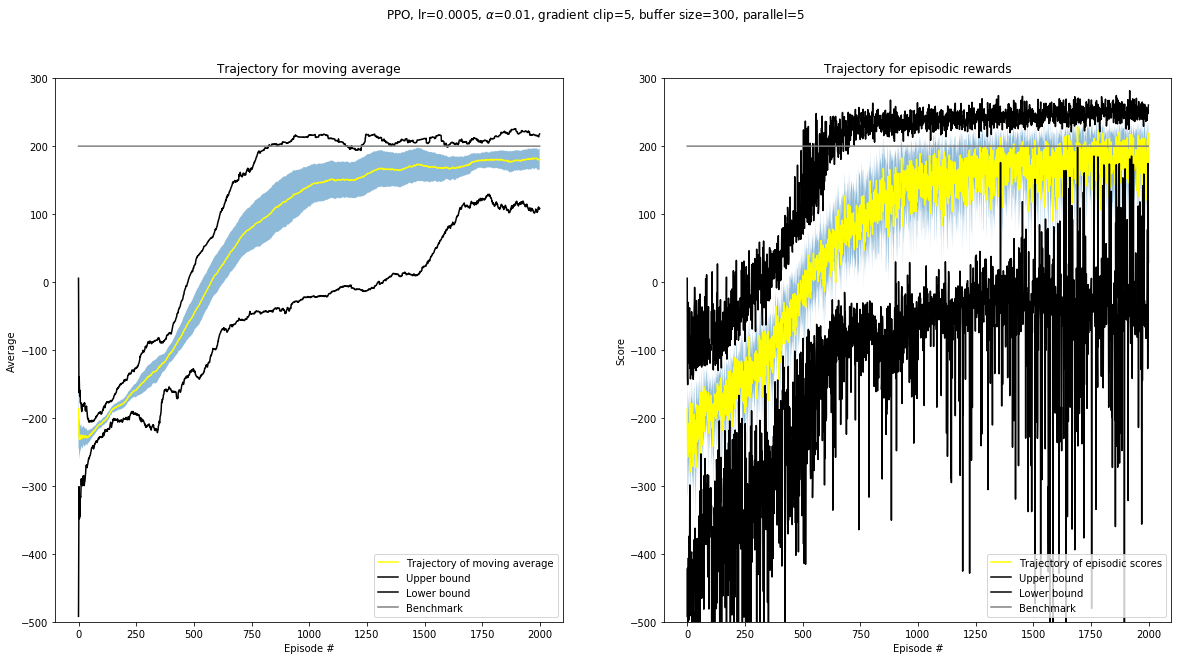

In [20]:
plot_result(scores, means, r'PPO, lr=0.0005, $\alpha$=0.01, gradient clip=5, buffer size=300, parallel=5')